### MSCI 598 - Final Project
### Gaurav Mudbhatkal - 20747018

In [1]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from gensim.models import Word2Vec
import numpy as np
import gc

#### Data Processing

In [2]:
from feature_engineering import refuting_features, polarity_features, hand_features, gen_or_load_feats
from feature_engineering import word_overlap_features
from feature_engineering import clean, normalize_word, get_tokenized_lemmas, remove_stopwords
from utils.dataset import DataSet
from utils.generate_test_splits import kfold_split, get_stances_for_folds
from utils.score import report_score, LABELS, score_submission
from utils.system import parse_params, check_version
import numpy as np
from tqdm import tqdm
import nltk
nltk.download('punkt')
nltk.download('wordnet')
dataset = DataSet()

def clean_data(stances, dataset):
    h, b, y = [], [], []
    for stance in stances:
        y.append(LABELS.index(stance['Stance']))
        h.append(stance['Headline'])
        b.append(dataset.articles[stance['Body ID']])
    X = []
    clean_headlines = []
    clean_bodies = []
    for i, (headline, body) in tqdm(enumerate(zip(h, b))):
        clean_headline = clean(headline)
        clean_body = clean(body)
        clean_headline = get_tokenized_lemmas(clean_headline)
        clean_body = get_tokenized_lemmas(clean_body)
        clean_headlines.append(clean_headline)
        clean_bodies.append(clean_body)
    return clean_headlines, clean_bodies, y

clean_headlines_comp, clean_bodies_comp, labels_comp = clean_data(dataset.stances,dataset)

clean_headlines_sent_comp = []
for headline in clean_headlines_comp:
    clean_headlines_sent_comp.append(" ".join(headline))
    
clean_bodies_sent_comp = []
for body in clean_bodies_comp:
    clean_bodies_sent_comp.append(" ".join(body))


Done
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Reading dataset
Total stances: 49972
Total bodies: 1683


49972it [03:16, 254.01it/s]


In [3]:
def train_word2vec(documents, embedding_dim):
    """
    train word2vector over traning documents
    Args:
        documents (list): list of document
        embedding_dim (int): outpu wordvector size
    Returns:
        word_vectors(dict): dict containing words and their respective vectors
    """
    model = Word2Vec(documents, min_count=2, size=embedding_dim)
    word_vectors = model.wv
    del model
    return word_vectors


def create_embedding_matrix(tokenizer, word_vectors, embedding_dim):
    """
    Create embedding matrix containing word indexes and respective vectors from word vectors
    Args:
        tokenizer (keras.preprocessing.text.Tokenizer): keras tokenizer object containing word indexes
        word_vectors (dict): dict containing word and their respective vectors
        embedding_dim (int): dimention of word vector
    Returns:
    """
    nb_words = len(tokenizer.word_index) + 1
    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((nb_words, embedding_dim))
    print("Embedding matrix shape: %s" % str(embedding_matrix.shape))
    for word, i in word_index.items():
        try:
            embedding_vector = word_vectors[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        except KeyError:
            print("vector not found for word - %s" % word)
    print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
    return embedding_matrix


def word_embed_meta_data(documents, embedding_dim):
    """
    Load tokenizer object for given vocabs list
    Args:
        documents (list): list of document
        embedding_dim (int): embedding dimension
    Returns:
        tokenizer (keras.preprocessing.text.Tokenizer): keras tokenizer object
        embedding_matrix (dict): dict with word_index and vector mapping
    """
    documents = [x.lower().split() for x in documents]
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(documents)
    word_vector = train_word2vec(documents, embedding_dim)
    embedding_matrix = create_embedding_matrix(tokenizer, word_vector, embedding_dim)
    del word_vector
    gc.collect()
    return tokenizer, embedding_matrix

In [4]:
def create_train_val_set(tokenizer, sentences_pair, stances, max_sequence_length, split_ratio):
    
    headlines = [x[0].lower() for x in sentences_pair]
    bodies = [x[1].lower() for x in sentences_pair]
    headline_sequences = tokenizer.texts_to_sequences(headlines)
    body_sequences = tokenizer.texts_to_sequences(bodies)

    train_padded_data_headlines = pad_sequences(headline_sequences, maxlen=max_sequence_length)
    train_padded_data_bodies = pad_sequences(body_sequences, maxlen=max_sequence_length)
    train_labels = np.array(stances)

    train_idx = max(1, int(len(train_labels) * split_ratio))

    train_data_headlines, val_data_headlines = train_padded_data_headlines[:-train_idx], train_padded_data_headlines[-train_idx:]
    train_data_bodies, val_data_bodies = train_padded_data_bodies[:-train_idx], train_padded_data_bodies[-train_idx:]
    labels_train, labels_val = train_labels[:-train_idx], train_labels[-train_idx:]
    leaks_train, leaks_val = leaks[:-train_idx], leaks[-train_idx:]

    return train_data_headlines, train_data_bodies, labels_train, leaks_train, val_data_headlines, val_data_bodies, labels_val, leaks_val


In [ ]:
tokenizer, embedding_matrix = word_embed_meta_data(clean_headlines_sent_comp + clean_bodies_sent_comp,  120)

embedding_meta_data = {'tokenizer': tokenizer,'embedding_matrix': embedding_matrix}

## creating sentence pairs
headline_body_pair = [(x1, x2) for x1, x2 in zip(clean_headlines_sent_comp, clean_bodies_sent_comp)]

In [6]:
from keras.utils.np_utils import to_categorical  

train_data_headlines, train_data_bodies, train_labels, leaks_train, val_data_headlines, val_data_bodies, val_labels, leaks_val = create_train_val_set(tokenizer, headline_body_pair, labels_comp, 200, 0.7)
y_train = to_categorical(train_labels, num_classes=4)
y_val = to_categorical(val_labels, num_classes=4)
embedding_dim = 120
max_sequence_length = 200
nb_words = len(tokenizer.word_index) + 1

In [7]:
from keras.layers import Dense, Input, LSTM, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization
from keras.layers.embeddings import Embedding
from keras.layers.merge import concatenate
from keras.callbacks import TensorBoard
from keras.models import load_model
from keras.models import Model

#### Bidirectional LSTM Implementation

In [8]:
# Creating word embedding layer
embedding_layer = Embedding(nb_words, embedding_dim, weights=[embedding_matrix],input_length=max_sequence_length, trainable=False)

# Creating LSTM Encoder
lstm_layer = Bidirectional(LSTM(100))

# Creating LSTM Encoder layer for headlines
sequence_headline_input = Input(shape=(max_sequence_length,), dtype='int32')
embedded_sequences_headlines = embedding_layer(sequence_headline_input)
headlines_lstm = lstm_layer(embedded_sequences_headlines)

# Creating LSTM Encoder layer for articles
sequence_body_input = Input(shape=(max_sequence_length,), dtype='int32')
embedded_sequences_bodies = embedding_layer(sequence_body_input)
bodies_lstm = lstm_layer(embedded_sequences_bodies)


In [9]:
# Merging two LSTM encodes vectors from headline, body pair to
# pass it to dense layer applying dropout and batch normalisation
# merged = concatenate(headlines_lstm, bodies_lstm)
merged = concatenate([headlines_lstm, bodies_lstm])
merged = BatchNormalization()(merged)
merged = Dropout(0.1)(merged)
merged = Dense(100, activation='relu')(merged)
merged = BatchNormalization()(merged)
merged = Dropout(0.1)(merged)
preds = Dense(4, activation='softmax')(merged)

model = Model(inputs=[sequence_headline_input, sequence_body_input], outputs=preds)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

STAMP = 'lstm_%d_%d_%.2f_%.2f' % (100, 200, 0.1, 0.1)
print(STAMP)

model.fit([train_data_headlines, train_data_bodies], y_train,
          validation_data=([val_data_headlines, val_data_bodies], y_val),
          epochs=10, batch_size=1500, callbacks=[early_stopping])

lstm_100_200_0.10_0.10
Epoch 1/10
10/10 [==============================] - 25s 2s/step - loss: 1.7165 - acc: 0.3204 - val_loss: 1.3096 - val_acc: 0.4889
Epoch 2/10
10/10 [==============================] - 15s 2s/step - loss: 1.2683 - acc: 0.4693 - val_loss: 1.2162 - val_acc: 0.6877
Epoch 3/10
10/10 [==============================] - 15s 2s/step - loss: 1.0654 - acc: 0.5863 - val_loss: 1.0962 - val_acc: 0.7799
Epoch 4/10
10/10 [==============================] - 15s 2s/step - loss: 0.9200 - acc: 0.6773 - val_loss: 0.9854 - val_acc: 0.7958
Epoch 5/10
10/10 [==============================] - 15s 2s/step - loss: 0.7950 - acc: 0.7411 - val_loss: 0.8668 - val_acc: 0.7868
Epoch 6/10
10/10 [==============================] - 15s 2s/step - loss: 0.6750 - acc: 0.7972 - val_loss: 0.7672 - val_acc: 0.7797
Epoch 7/10
10/10 [==============================] - 15s 2s/step - loss: 0.5790 - acc: 0.8316 - val_loss: 0.7037 - val_acc: 0.7703
Epoch 8/10
10/10 [==============================] - 15s 2s/step - l

In [10]:
competition_dataset = DataSet("competition_test")

clean_headlines_competition, clean_bodies_competition, labels_competition = clean_data(competition_dataset.stances,competition_dataset)
X_competition, y_competition = generate_features(competition_dataset.stances, competition_dataset, "competition")

clean_headlines_sent_competition = []
for headline in clean_headlines_competition:
    clean_headlines_sent_competition.append(" ".join(headline))
    
clean_bodies_sent_competition = []
for body in clean_bodies_competition:
    clean_bodies_sent_competition.append(" ".join(body))

headline_body_pair_competition = [(x1, x2) for x1, x2 in zip(clean_headlines_sent_competition, clean_bodies_sent_competition)]

def create_comp_test_set(tokenizer, sentences_pair, stances, max_sequence_length):
    
    headlines = [x[0].lower() for x in sentences_pair]
    bodies = [x[1].lower() for x in sentences_pair]
    headline_sequences = tokenizer.texts_to_sequences(headlines)
    body_sequences = tokenizer.texts_to_sequences(bodies)

    test_padded_data_headlines = pad_sequences(headline_sequences, maxlen=max_sequence_length)
    test_padded_data_bodies = pad_sequences(body_sequences, maxlen=max_sequence_length)
    test_labels = np.array(stances)


    return test_padded_data_headlines, test_padded_data_bodies, test_labels

test_headlines, test_bodies, test_labels = create_comp_test_set(tokenizer, headline_body_pair_competition, labels_competition, 200)



Reading dataset
Total stances: 25413
Total bodies: 904


25413it [01:29, 285.49it/s]


In [11]:
preds = model.predict([test_headlines, test_bodies])
len(preds)

# prediction_stances = np.argmax(preds)
predicted = [LABELS[int(np.argmax(a))] for a in preds]
actual = [LABELS[int(a)] for a in labels_competition]

report_score(predicted,actual)

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     0     |     0     |     0     |     0     |
-------------------------------------------------------------
| disagree  |     0     |     0     |     0     |     0     |
-------------------------------------------------------------
|  discuss  |     0     |     0     |    31     |     3     |
-------------------------------------------------------------
| unrelated |   1903    |    697    |   4433    |   18346   |
-------------------------------------------------------------
Score: 4617.5 out of 6378.75	(72.38879090730943%)


72.38879090730943

In [16]:
from sklearn.metrics import precision_score, recall_score
precision_score(predicted, actual, average='macro'), recall_score(predicted, actual, average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.25169523694903145, 0.4086614570174971)

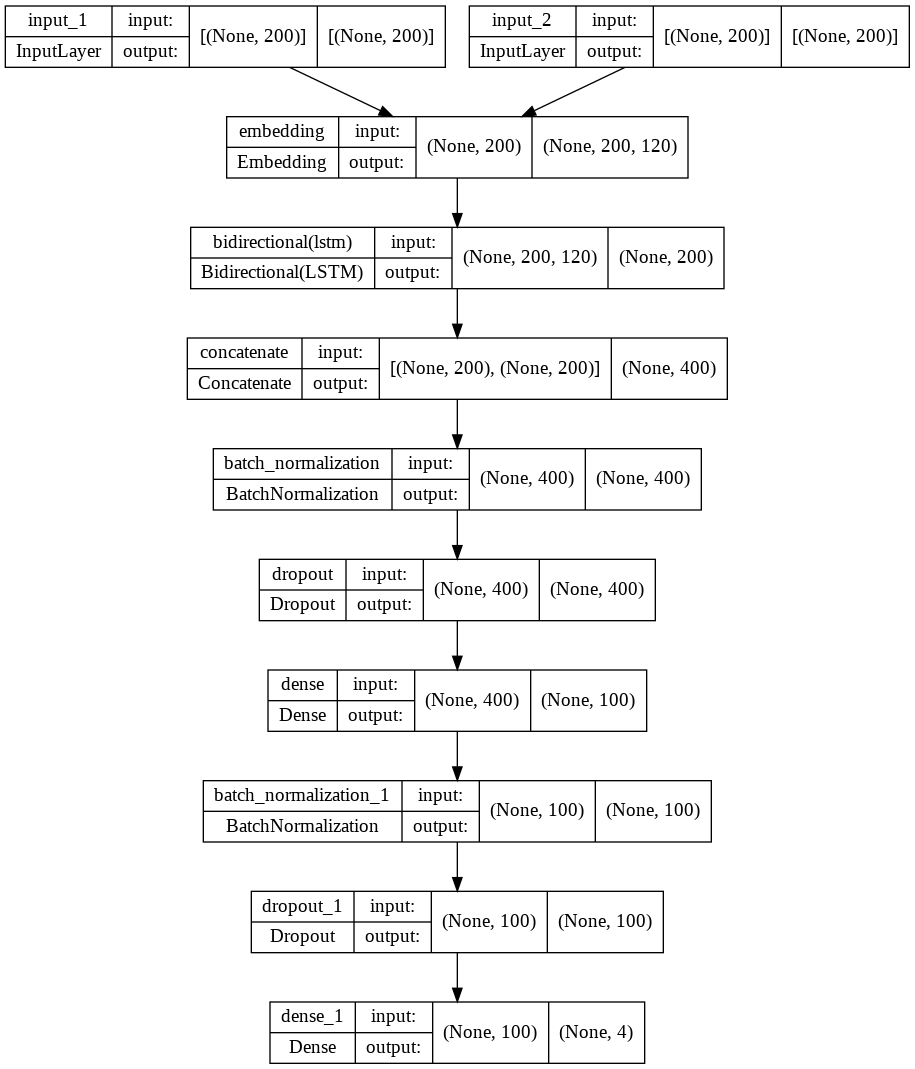

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_dense.png', show_shapes=True, show_layer_names=True)
# some results
# without batch normalizing(10 epochs): 53%
# with batch normalizing(10 epochs): 71%
# with batch normalizing(20 epochs): 45%
# with batch normalizing(15 epochs, 800 batch): 43%
# with batch normalizing(50 epochs): 50%